# IBM Data Science Capstone Project

This notebook will guide you through a theoretical business problem. 
The question that we are trying to answer is the following:

**A successful owner of multiple mid-high-end restaurants decided to open a new restaurant in Dubai, UAE. Having visited the city many times in the recent years, he couldn't disregard the big boom in gastronomy in the city. He is keen on opening a new unit which will focus on the European and Asian fusion kitchen.**

Taking into account the price level that the restaurant will operate, the intent is to find an optimal place in an area, where gastronomy is booming and easily accessible for tourists and for wealthier local citizens as well.

<h3>Assumptions, business logic:</h3>

The assumption behind the analysis is that we can use unsupervised machine learning to create clusters of districts that will provide us a list of areas for consideration for the restaurant. The intent is that the restaurant to be situated close one of the gastronomical centers.

To do this, we will need the following data:
1. List of the districts of Dubai -> List of communities will be obtained from Wikipedia. (https://en.wikipedia.org/wiki/List_of_communities_in_Dubai)
2. Geo-coordinates of the communities in Dubai -> this is obtained via geocoder
3. Top venues of communities -> Foursquare API is used to collect the venue data

## Methodology:

After tidying up the data, we will apply K-means machine learning technique for creating clusters of districts. We will use silhouette score for choosing the optimal number of clusters.

#### Limitations:
The analysis has some limitations that should be taken into account. Some limitations:
1. The analsiss is performed on a community level.
2. When collecting venues a 1000 meter radius is used around the center coordinates of the communities. The number of collected venues is limited to 100 per community.




### Importing libraries

In [28]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import geocoder 

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library


print('Libraries imported.')

Libraries imported.


# 1. Putting the Data together

## Dubai Communities


We get the list of communities from wikipedia url. 

In [98]:
df_data_1 = pd.read_html("https://en.wikipedia.org/wiki/List_of_communities_in_Dubai")
dxb_df = df_data_1[0]

dxb_df.drop(["Community (Arabic)","Area(km2)","Population(2000)","Population density(/km2)","Community Seat"],axis=1,inplace = True)
dxb_df.rename(columns={"Community (English)":"Community Name"},inplace=True)

dxb_df


,Community Number,Community Name
0,126.0,Abu Hail
1,711.0,Al Awir First
2,721.0,Al Awir Second
3,333.0,Al Bada
4,122.0,Al Baraha
5,373.0,Al Barsha First
6,376.0,Al Barsha Second
7,671.0,Al Barsha South First
8,672.0,Al Barsha South Second
9,673.0,Al Barsha South Third


In [21]:
dxb_df.shape

(132, 2)

Getting the geo-coordinates for the Communities

In [99]:
   
def get_latlng(neighborhoods):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Dubai, UAE'.format(neighborhoods))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coordinates = [ get_latlng(neighborhoods) for neighborhoods in dxb_df["Community Name"].tolist() ]
coordinates




[[25.28308000000004, 55.33435000000003],
 [25.186050000000023, 55.54108000000008],
 [25.167920000000038, 55.543310000000076],
 [25.21861000000007, 55.26406000000003],
 [25.282800000000066, 55.31678000000005],
 [25.11483000000004, 55.19136000000003],
 [25.107230000000072, 55.20485000000008],
 [25.08958000000007, 55.23424000000006],
 [25.077390000000037, 55.24267000000003],
 [25.062290000000075, 55.23995000000008],
 [25.093420000000037, 55.19044000000008],
 [25.269250000000056, 55.29944000000006],
 [25.272170000000074, 55.30157000000003],
 [25.243370000000027, 55.352670000000046],
 [25.269510000000025, 55.30884000000003],
 [25.25696000000005, 55.30246000000005],
 [25.29871000000003, 55.33546000000007],
 [25.237130000000036, 55.27707000000004],
 [25.220540000000028, 55.34166000000005],
 [25.233420000000024, 55.29001000000005],
 [25.245290000000068, 55.30364000000003],
 [25.27177000000006, 55.33762000000007],
 [25.24282000000005, 55.48440000000005],
 [25.22784000000007, 55.522320000000036]

### Creating the dataframe which will contain latitude and longitude data

In [100]:
dxb_neighbors = pd.DataFrame(coordinates, columns=['Latitude', 'Longitude'])

dxb_df['Latitude'] = dxb_neighbors['Latitude']
dxb_df['Longitude'] = dxb_neighbors['Longitude']

dxb_df

,Community Number,Community Name,Latitude,Longitude
0,126.0,Abu Hail,25.283080,55.334350
1,711.0,Al Awir First,25.186050,55.541080
2,721.0,Al Awir Second,25.167920,55.543310
3,333.0,Al Bada,25.218610,55.264060
4,122.0,Al Baraha,25.282800,55.316780
5,373.0,Al Barsha First,25.114830,55.191360
6,376.0,Al Barsha Second,25.107230,55.204850
7,671.0,Al Barsha South First,25.089580,55.234240
8,672.0,Al Barsha South Second,25.077390,55.242670
9,673.0,Al Barsha South Third,25.062290,55.239950


### Mapping Dubai with the Communities

#### First, let's find the geodata for Dubai

In [59]:
# Getting Dubai Down Town coordinates as it's in the row index 80 of hte dataframe
dxb_lat = dxb_df.loc[80,'Latitude']
dxb_long = dxb_df.loc[80,'Longitude']

#### Let's create a map, with showing the communities


In [104]:
dxb_map = folium.Map(location=[dxb_lat, dxb_long], zoom_start=11)

# add markers to map
for lat, lng, cmty in zip(dxb_df['Latitude'], dxb_df['Longitude'], dxb_df['Community Name']):
    label = '{}'.format(cmty)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3906cc',
        fill_opacity=0.7,
        parse_html=False).add_to(dxb_map)  
    
dxb_map

# 2. Exploring the Communities

## Exploring Top Communities Venues with Foursquare

Foursquare credentials

In [53]:
CLIENT_ID = 'DVXW3UVJJFWMX5M5K4QEO1HCVRUCE3JYOQVGDVDGMFXLWPQZ' #  Foursquare ID
CLIENT_SECRET = 'QEXXMGKR10KEP0UPNLR4ODZTAQJ2UBSJHOZPIREQ0OIV5QCH' # Foursquare Secret
VERSION = '20200820' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DVXW3UVJJFWMX5M5K4QEO1HCVRUCE3JYOQVGDVDGMFXLWPQZ
CLIENT_SECRET:QEXXMGKR10KEP0UPNLR4ODZTAQJ2UBSJHOZPIREQ0OIV5QCH


## Exploring the first Community

In [105]:
dxb_df.loc[0, 'Community Name']

'Abu Hail'

Getting the Community's geo coordinates

In [61]:
neighborhood_latitude = dxb_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = dxb_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = dxb_df.loc[0, 'Community Name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Abu Hail are 25.28308000000004, 55.33435000000003.


Getting the top 100 venues that are in Abu Hail (First Community) within a radius of 1000 meters.
This will be obtained from Foursquare.

In [62]:
search_query = 'venues'
radius = 1000
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url


'https://api.foursquare.com/v2/venues/explore?&client_id=DVXW3UVJJFWMX5M5K4QEO1HCVRUCE3JYOQVGDVDGMFXLWPQZ&client_secret=QEXXMGKR10KEP0UPNLR4ODZTAQJ2UBSJHOZPIREQ0OIV5QCH&v=20200820&ll=25.28308000000004,55.33435000000003&radius=1000&limit=100'

Getting the json of venues

In [63]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f3ea884d04dfc25daaf7871'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Deira',
  'headerFullLocation': 'Deira, Dubai',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 15,
  'suggestedBounds': {'ne': {'lat': 25.29208000900005,
    'lng': 55.34428487988184},
   'sw': {'lat': 25.274079991000033, 'lng': 55.32441512011822}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c9fa8e6d3c2b60c9997d6bc',
       'name': 'Habib Bakery',
       'location': {'lat': 25.2811237096868,
        'lng': 55.33277444336266,
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.2811237096868,
          'lng': 55.33277444336266}],
   

Defining a function to get categories

In [64]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Tidying up the data 

In [65]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

C:\Users\o.ahmad.sirka\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,Habib Bakery,4c9fa8e6d3c2b60c9997d6bc,Bakery,25.281124,55.332774
1,Gold's Gym,51259fb3e4b03c62534ccbf1,Gym,25.282698,55.341019
2,Al Douri Roastery,4ce2025baba88cfaf7dd58d7,Bakery,25.277057,55.328223
3,Union Co-Operative Society,4c6ed8f2b5a5236abf5c4b52,Department Store,25.282769,55.340896
4,McDonald's,4ce9396cd99f721e3d0fb573,Fast Food Restaurant,25.282839,55.340780
5,McDonald's (ماكدونالدز),4f3ca0f4754a0129f471dabb,Fast Food Restaurant,25.283117,55.341371
6,Mister Baker,4ce200ef70bba1cda0d574c4,Dessert Shop,25.277100,55.328042
7,Karachi darbar,4c7d2a10b33a224ba42ad781,Indian Restaurant,25.274751,55.331074
8,Bait Al Jinnie Junction,4c23a69bf1272d7fc3c581c5,Scenic Lookout,25.280546,55.330471
9,Hamriya Park,4f917049e4b0c93d7f58fc4d,Park,25.285710,55.333000


In [66]:
#fix the column names

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,id,categories,lat,lng
0,Habib Bakery,4c9fa8e6d3c2b60c9997d6bc,Bakery,25.281124,55.332774
1,Gold's Gym,51259fb3e4b03c62534ccbf1,Gym,25.282698,55.341019
2,Al Douri Roastery,4ce2025baba88cfaf7dd58d7,Bakery,25.277057,55.328223
3,Union Co-Operative Society,4c6ed8f2b5a5236abf5c4b52,Department Store,25.282769,55.340896
4,McDonald's,4ce9396cd99f721e3d0fb573,Fast Food Restaurant,25.282839,55.340780
5,McDonald's (ماكدونالدز),4f3ca0f4754a0129f471dabb,Fast Food Restaurant,25.283117,55.341371
6,Mister Baker,4ce200ef70bba1cda0d574c4,Dessert Shop,25.277100,55.328042
7,Karachi darbar,4c7d2a10b33a224ba42ad781,Indian Restaurant,25.274751,55.331074
8,Bait Al Jinnie Junction,4c23a69bf1272d7fc3c581c5,Scenic Lookout,25.280546,55.330471
9,Hamriya Park,4f917049e4b0c93d7f58fc4d,Park,25.285710,55.333000


## Now let's explore the other Communitis as well

for that, let's create a function

In [67]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Let's collect the data

In [69]:
dxb_venues = getNearbyVenues(names=dxb_df['Community Name'],
                                   latitudes=dxb_df['Latitude'],
                                   longitudes=dxb_df['Longitude']
                                  )

Abu Hail
Al Awir First
Al Awir Second
Al Bada
Al Baraha
Al Barsha First
Al Barsha Second
Al Barsha South First
Al Barsha South Second
Al Barsha South Third
Al Barsha Third
Al Buteen
Al Dhagaya
Al Garhoud
Al Guoz Fourth
Al Hamriya, Dubai
Al Hamriya Port
Al Hudaiba
Al Jaddaf
Al Jafiliya
Al Karama
Al Khabisi
Al Khwaneej First
Al Khwaneej Second
Al Kifaf
Al Mamzar
Al Manara
Al Mankhool
Al Merkad
Al Mina
Al Mizhar First
Al Mizhar Second
Al Muraqqabat
Al Murar
Al Mushrif
Al Muteena
Al Nahda First
Al Nahda Second
Al Nasr, Dubai
Al Quoz First
Al Quoz Industrial First
Al Quoz Industrial Fourth
Al Quoz Industrial Second
Al Quoz Industrial Third
Al Quoz Second
Al Quoz Third
Al Qusais First
Al Qusais Industrial Fifth
Al Qusais Industrial First
Al Qusais Industrial Fourth
Al Qusais Industrial Second
Al Qusais Industrial Third
Al Qusais Second
Al Qusais Third
Al Raffa
Al Ras
Al Rashidiya
Al Rigga
Al Sabkha
Al Safa First
Al Safa Second
Al Safouh First
Al Safouh Second
Al Satwa
Al Shindagha
Al Souq Al

In [71]:
print(dxb_venues.shape)
dxb_venues.head()

(5535, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abu Hail,25.28308,55.33435,Habib Bakery,25.281124,55.332774,Bakery
1,Abu Hail,25.28308,55.33435,Gold's Gym,25.282698,55.341019,Gym
2,Abu Hail,25.28308,55.33435,Al Douri Roastery,25.277057,55.328223,Bakery
3,Abu Hail,25.28308,55.33435,Union Co-Operative Society,25.282769,55.340896,Department Store
4,Abu Hail,25.28308,55.33435,McDonald's,25.282839,55.340780,Fast Food Restaurant


Now, checking how many venues were collected for other Communities as well. 

In [73]:
dxb_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abu Hail,15,15,15,15,15,15
Al Awir First,4,4,4,4,4,4
Al Awir Second,5,5,5,5,5,5
Al Bada,56,56,56,56,56,56
Al Baraha,19,19,19,19,19,19
Al Barsha First,83,83,83,83,83,83
Al Barsha Second,99,99,99,99,99,99
Al Barsha South First,8,8,8,8,8,8
Al Barsha South Second,12,12,12,12,12,12


### Checking how many Communitis venue categories we have

In [74]:
print('There are {} uniques categories.'.format(len(dxb_venues['Venue Category'].unique())))

There are 320 uniques categories.


# 3. Analyzing the Communities

For that, we use one hot encoding.

In [75]:
# one hot encoding
dubai_onehot = pd.get_dummies(dxb_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dubai_onehot['Neighborhood'] = dxb_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dubai_onehot.columns[-1]] + list(dubai_onehot.columns[:-1])
dubai_onehot = dubai_onehot[fixed_columns]

dubai_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Belgian Restaurant,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kurdish Restaurant,Lake,Latin American Restaurant,Laundromat,Lebanese Restaurant,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mobility Store,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Other Repair Shop,Outlet Store,Paintball Field,Pakistani Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Port,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shawarma Place,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa

In [76]:
dubai_onehot.shape

(5535, 320)

Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [77]:
dubai_grouped = dubai_onehot.groupby('Neighborhood').mean().reset_index()
dubai_grouped

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Belgian Restaurant,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kurdish Restaurant,Lake,Latin American Restaurant,Laundromat,Lebanese Restaurant,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mobility Store,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Other Repair Shop,Outlet Store,Paintball Field,Pakistani Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Port,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shawarma Place,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa

### Let's see each neighborhood along with the top 5 most common venues

In [78]:
num_top_venues = 5

for hood in dubai_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = dubai_grouped[dubai_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abu Hail----
                  venue  freq
0     Indian Restaurant  0.13
1  Fast Food Restaurant  0.13
2                Bakery  0.13
3      Department Store  0.13
4                  Park  0.07


----Al Awir First----
                 venue  freq
0                 Café  0.75
1            Cafeteria  0.25
2          Zoo Exhibit  0.00
3  Moroccan Restaurant  0.00
4               Office  0.00


----Al Awir Second----
               venue  freq
0  Indian Restaurant   0.2
1     Clothing Store   0.2
2       Burger Joint   0.2
3        Coffee Shop   0.2
4               Café   0.2


----Al Bada----
                       venue  freq
0                       Café  0.14
1                Coffee Shop  0.11
2  Middle Eastern Restaurant  0.07
3       Gym / Fitness Center  0.05
4                     Bakery  0.04


----Al Baraha----
                 venue  freq
0                Hotel  0.26
1    Indian Restaurant  0.05
2  American Restaurant  0.05
3                 Café  0.05
4          Coffee Shop  0

4                     Noodle House   0.0


----Al Warqa'a Second----
                       venue  freq
0                     Market   0.1
1               Burger Joint   0.1
2                  Cafeteria   0.1
3  Middle Eastern Restaurant   0.1
4                  Bookstore   0.1


----Al Warqa'a Third----
               venue  freq
0        Gas Station   0.2
1  Indian Restaurant   0.2
2          Cafeteria   0.2
3               Park   0.2
4      Shopping Mall   0.2


----Al Wasl----
                       venue  freq
0                      Hotel  0.09
1                     Lounge  0.07
2          Indian Restaurant  0.05
3                       Café  0.05
4  Middle Eastern Restaurant  0.04


----Aleyas----
                     venue  freq
0                  Stables   0.5
1         Kebab Restaurant   0.5
2              Zoo Exhibit   0.0
3              Music Store   0.0
4  North Indian Restaurant   0.0


----Arabian Ranches----
          venue  freq
0    Restaurant  0.13
1   Coffee Shop  0.

Putting it into a dataframe

In [79]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [80]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dubai_grouped['Neighborhood']

for ind in np.arange(dubai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dubai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abu Hail,Department Store,Bakery,Fast Food Restaurant,Indian Restaurant,Spa,Scenic Lookout,Gym,Track,Market,Dessert Shop
1,Al Awir First,Café,Cafeteria,Fondue Restaurant,Flower Shop,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant
2,Al Awir Second,Café,Clothing Store,Indian Restaurant,Burger Joint,Coffee Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant
3,Al Bada,Café,Coffee Shop,Middle Eastern Restaurant,Gym / Fitness Center,Burger Joint,Bakery,Flower Shop,Bridal Shop,Supermarket,Beach
4,Al Baraha,Hotel,American Restaurant,Middle Eastern Restaurant,Fried Chicken Joint,Lounge,Bar,Café,Asian Restaurant,Post Office,Turkish Restaurant


##  Using Machine Learning for Clustering Neighborhoods

For clustering, K-means method will be applied. To be able to select the optimal number of clusters,  the silhouette score will be used.

First, let's find out the optimal number of clusters. For that, we will create a graph of the silhouette scores.

In [183]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [184]:
max_range = 8

dubai_grouped_clustering = dubai_grouped.drop('Neighborhood', 1)

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(4, max_range) :
    
    # Run k-means clustering
    kmc = dubai_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)
    

scores,indices

([0.4383539319505212,
  0.23685914522761684,
  0.43398482630043467,
  0.06449303412270795],
 [4, 5, 6, 7])

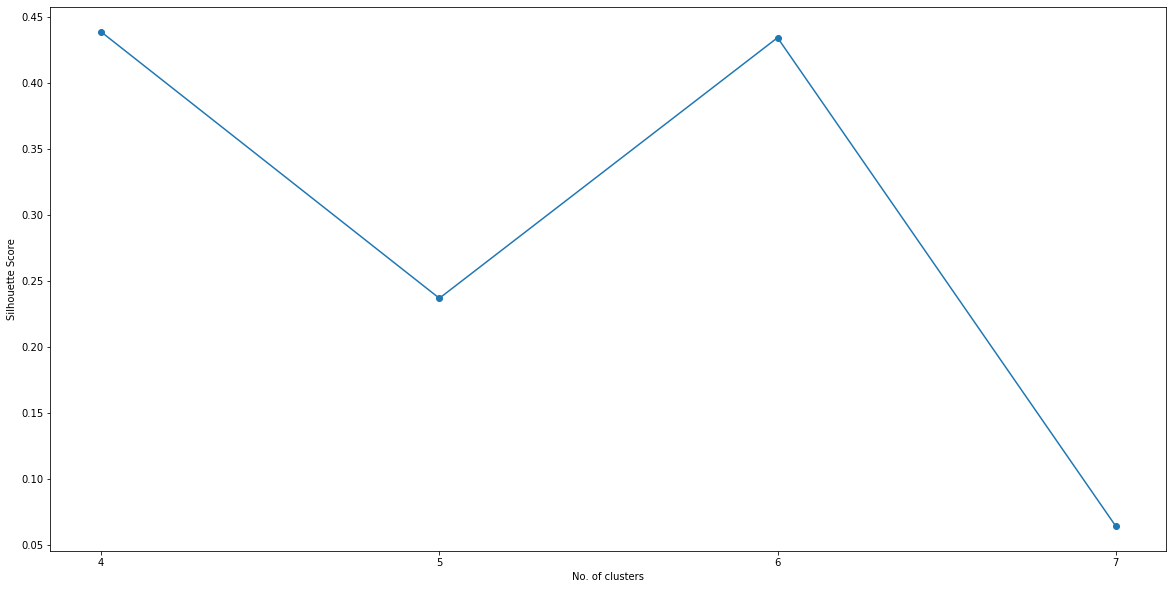

In [182]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

Based on this graph, we can see that the optimal number of clusters is 2.

Now let's run the K-means clustering with the optimal number of clusters, which is 2.

In [211]:
# run k-means clustering
kmeans = KMeans(n_clusters=6, random_state=0).fit(dubai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


array([1, 3, 1, 1, 1, 1, 1, 1, 1, 1])

In [197]:
# rename the Community Name column

dxb_df.rename(columns={'Community Name':'Neighborhood'}, inplace=True)
dxb_df

,Community Number,Neighborhood,Latitude,Longitude
0,126.0,Abu Hail,25.283080,55.334350
1,711.0,Al Awir First,25.186050,55.541080
2,721.0,Al Awir Second,25.167920,55.543310
3,333.0,Al Bada,25.218610,55.264060
4,122.0,Al Baraha,25.282800,55.316780
5,373.0,Al Barsha First,25.114830,55.191360
6,376.0,Al Barsha Second,25.107230,55.204850
7,671.0,Al Barsha South First,25.089580,55.234240
8,672.0,Al Barsha South Second,25.077390,55.242670
9,673.0,Al Barsha South Third,25.062290,55.239950


In [201]:
# add clustering labels
#neighborhoods_venues_sorted.drop('Cluster Labels', axis=1,inplace= True)
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

dubai_merged = dxb_df

# merge dubai_grouped with Dubai_data to add latitude/longitude for each neighborhood
dubai_merged = dubai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

dubai_merged.fillna(0,inplace= True)
dubai_merged



,Community Number,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,126.0,Abu Hail,25.283080,55.334350,1.0,Department Store,Bakery,Fast Food Restaurant,Indian Restaurant,Spa,Scenic Lookout,Gym,Track,Market,Dessert Shop
1,711.0,Al Awir First,25.186050,55.541080,3.0,Café,Cafeteria,Fondue Restaurant,Flower Shop,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant
2,721.0,Al Awir Second,25.167920,55.543310,1.0,Café,Clothing Store,Indian Restaurant,Burger Joint,Coffee Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant
3,333.0,Al Bada,25.218610,55.264060,1.0,Café,Coffee Shop,Middle Eastern Restaurant,Gym / Fitness Center,Burger Joint,Bakery,Flower Shop,Bridal Shop,Supermarket,Beach
4,122.0,Al Baraha,25.282800,55.316780,1.0,Hotel,American Restaurant,Middle Eastern Restaurant,Fried Chicken Joint,Lounge,Bar,Café,Asian Restaurant,Post Office,Turkish Restaurant
5,373.0,Al Barsha First,25.114830,55.191360,1.0,Hotel,Clothing Store,Coffee Shop,Bed & Breakfast,Pakistani Restaurant,Dessert Shop,Breakfast Spot,Lounge,Asian Restaurant,Middle Eastern Restaurant
6,376.0,Al Barsha Second,25.107230,55.204850,1.0,Hotel,Indian Restaurant,Middle Eastern Restaurant,Coffee Shop,Restaurant,Bed & Breakfast,Ice Cream Shop,Gym / Fitness Center,Pizza Place,Bakery
7,671.0,Al Barsha South First,25.089580,55.234240,1.0,Bakery,Shopping Mall,Falafel Restaurant,Grocery Store,Fast Food Restaurant,Fried Chicken Joint,Moving Target,Egyptian Restaurant,Electronics Store,English Restaurant
8,672.0,Al Barsha South Second,25.077390,55.242670,1.0,Café,Supermarket,Department Store,Hotel,Fast Food Restaurant,Office,Coffee Shop,Shopping Mall,Gym,Moving Target
9,673.0,Al Barsha South Third,25.062290,55.239950,1.0,Theme Park,Department Store,Fast Food Restaurant,Shopping Mall,Motorcycle Shop,Supermarket,Burger Joint,Garden,Cafeteria,Café


### Now, visualizing the clusters

In [218]:
# create map
map_clusters = folium.Map(location=[dxb_lat, dxb_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
clstr_lbl = dubai_merged['Cluster Labels']
clstr_lbl = clstr_lbl.astype(int)

markers_colors = []
for lat, lon, poi,cluster in zip(dubai_merged['Latitude'], dubai_merged['Longitude'], dubai_merged['Neighborhood'],clstr_lbl):
    label = folium.Popup(str(poi) + ' Cluster '+ str(cluster) , parse_html=True)
 
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
       
map_clusters

## Examining Clusters

### Cluster 1

In [212]:
dubai_merged.loc[dubai_merged['Cluster Labels'] == 0, dubai_merged.columns[[1] + list(range(5, dubai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Al Khwaneej Second,0,0,0,0,0,0,0,0,0,0
91,Jebel Ali Industrial,Restaurant,Zoo,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Eye Doctor,Falafel Restaurant
92,Jebel Ali Palm,Restaurant,Zoo,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Eye Doctor,Falafel Restaurant
129,Yaraah,0,0,0,0,0,0,0,0,0,0


### Cluster 2

In [213]:
dubai_merged.loc[dubai_merged['Cluster Labels'] == 1, dubai_merged.columns[[1] + list(range(5, dubai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abu Hail,Department Store,Bakery,Fast Food Restaurant,Indian Restaurant,Spa,Scenic Lookout,Gym,Track,Market,Dessert Shop
2,Al Awir Second,Café,Clothing Store,Indian Restaurant,Burger Joint,Coffee Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant
3,Al Bada,Café,Coffee Shop,Middle Eastern Restaurant,Gym / Fitness Center,Burger Joint,Bakery,Flower Shop,Bridal Shop,Supermarket,Beach
4,Al Baraha,Hotel,American Restaurant,Middle Eastern Restaurant,Fried Chicken Joint,Lounge,Bar,Café,Asian Restaurant,Post Office,Turkish Restaurant
5,Al Barsha First,Hotel,Clothing Store,Coffee Shop,Bed & Breakfast,Pakistani Restaurant,Dessert Shop,Breakfast Spot,Lounge,Asian Restaurant,Middle Eastern Restaurant
6,Al Barsha Second,Hotel,Indian Restaurant,Middle Eastern Restaurant,Coffee Shop,Restaurant,Bed & Breakfast,Ice Cream Shop,Gym / Fitness Center,Pizza Place,Bakery
7,Al Barsha South First,Bakery,Shopping Mall,Falafel Restaurant,Grocery Store,Fast Food Restaurant,Fried Chicken Joint,Moving Target,Egyptian Restaurant,Electronics Store,English Restaurant
8,Al Barsha South Second,Café,Supermarket,Department Store,Hotel,Fast Food Restaurant,Office,Coffee Shop,Shopping Mall,Gym,Moving Target
9,Al Barsha South Third,Theme Park,Department Store,Fast Food Restaurant,Shopping Mall,Motorcycle Shop,Supermarket,Burger Joint,Garden,Cafeteria,Café
10,Al Barsha Third,Restaurant,Lebanese Restaurant,Convenience Store,Sandwich Place,Fast Food Restaurant,Coffee Shop,Bakery,Racetrack,English Restaurant,Duty-free Shop


### Cluster 3

In [214]:
dubai_merged.loc[dubai_merged['Cluster Labels'] == 2, dubai_merged.columns[[1] + list(range(5, dubai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
126,Wadi Alamardi,Farm,Campground,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Eye Doctor,Falafel Restaurant


### Cluster 4

In [215]:
dubai_merged.loc[dubai_merged['Cluster Labels'] == 3, dubai_merged.columns[[1] + list(range(5, dubai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Al Awir First,Café,Cafeteria,Fondue Restaurant,Flower Shop,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant
22,Al Khwaneej First,Café,Coffee Shop,Burger Joint,Cafeteria,Bakery,Poke Place,Comfort Food Restaurant,Shopping Plaza,Juice Bar,Eye Doctor
111,Oud Al Muteena Third,Café,Gym Pool,Zoo,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Eye Doctor


### Cluster 5

In [216]:
dubai_merged.loc[dubai_merged['Cluster Labels'] == 4, dubai_merged.columns[[1] + list(range(5, dubai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,Aleyas,Kebab Restaurant,Stables,Zoo,Farm,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Eye Doctor


### Cluster 6

In [217]:
dubai_merged.loc[dubai_merged['Cluster Labels'] == 5, dubai_merged.columns[[1] + list(range(5, dubai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
106,Nadd Al Shiba Third,Art Gallery,Pizza Place,Pet Store,Falafel Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant


# 4. Conclusion

### Understanding the Clusters

## That's all folks, Thanks for giving the time for going over my code.. please feel free to ask for any clarification 

By looking at the cluster data, we can see that **cluster 2** is the one that we are the most interested in. 

**Clusters 2,4,5** are an outer Communities where top gastronomy is not really represented .

**Cluster 3** this community can be also considerd also as an interested one as the most commin venus arround are Coffe shops or fast food resturants. 


### Based on that, we can advise the restaurant owner to consider the Communities from this **cluster 2** as the potential location for the new restaurant.

----

## Thank you for going over my code, please feel free to ask about any clarification.

In [219]:
# prepared by Ahmad Sirka